In [49]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_del_accumulation_attr
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import requests
import json

## Figure 1: Accumulation of nonsynonymous S1 mutations is correlated with clade success

##### The accumulation of mutations in different regions of the genome is counted and plotted over time to show that some regions amass nonsynonymous substitions at higher rates than others.

##### Mutation accumulation is then compared to logistic growth rate to determine whether mutations within certain regions of the genome correlate with the success of SARS-CoV-2 clades.

#### This notebook completes the analysis for Figure 1 A and B, as well as Figure 1 Supplement 2. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add information about synonymous mutations as an attribute of nodes on the tree

In [4]:
tree = add_syn_mut_attribute(tree)

Add an attribute to each node that gives the total number of mutations (synonymous SNPs, or nonsynonymous SNPs plus deletions) accumulated between the tree root and that node (including mutations on the node). 

In [5]:
tree = add_mut_accumulation_attr(tree)

Add an attribute to each node that lists deletions and nonsynonymous SNPs separately

In [6]:
tree = add_del_accumulation_attr(tree)

Make a list of regions of the genome to consider. Each element of the list is a tuple with the format: 
(region/type of mutation, node attribute name, gene length for normalizing mutation count, nonsynonymous or synonymous)

In [30]:
regions_to_consider = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S1_synonymous', 's1_syn_accumulation', 'S1', 'syn'), 
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('E', 'e_accumulation', 'E', 'nonsyn'), ('M', 'm_accumulation', 'M', 'nonsyn'), 
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn'), 
                       ('S2', 's2_accumulation', 'S2', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn'), 
                       ('RdRp_synonymous', 'rdrp_syn_accumulation', 'RdRp', 'syn')]


Make a tidy dataframe to plot: 
1) accumulation of mutations over time for each region of the genome

2) mutation accumulation versus logistic growth

In [31]:
# initialize list to store relevant information for Fig1A and B
muts_information = []

# only look at internal nodes
for node in tree.find_clades(terminal=False):

    # only nodes within 6 weeks of May 15 have logisitic growth rates
    logistic_growth = None
    if "logistic_growth" in node.node_attrs:
        logistic_growth = node.node_attrs["logistic_growth"]["value"]
    
    if hasattr(node, "node_attrs"):
        # get inferred node date
        date = node.node_attrs["num_date"]["value"]
        
        # get emerging lineage assignment of node 
        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']
            emerging_lineage = convert_linege_names(emerging_lineage)
            manuscript_lineage = node.node_attrs['manuscript_lineage']['value']

        # make tidy df for seaborn plotting
        for r in regions_to_consider:
            # there are no synonymous deletions, but S1 deletions will be stored with S1_syn mut information-> these will not be plotted
            # add figure_lineage key to group 
            muts_information.append({'clade': node.name, 'date': date,
                                     'emerging_lineage': emerging_lineage,
                                     'manuscript_lineage': manuscript_lineage,
                                     'mut_location': r[0], 
                                     'num_muts': node.node_attrs[r[1]],  
                                     'muts_per_codon': node.node_attrs[r[1]]/gene_lengths_aa[r[2]],
                                     'num_deletions': node.node_attrs['deletion_accumulation'][r[2]], 
                                     'dels_per_codon': node.node_attrs['deletion_accumulation'][r[2]]/gene_lengths_aa[r[2]],
                                     'snps_per_codon': node.node_attrs['nonsyn_snps_accumulation'][r[2]]/gene_lengths_aa[r[2]],
                                     'logistic_growth': logistic_growth})


# make list into dataframe
muts_information_df = pd.DataFrame(muts_information)

Export the R value for the correlation between mutation accumulation and logistic growth rate. These R values from the empirical correlations will be compared to R values from randomized trees in the notebook "fig1c_randomization.ipynb"

In [ ]:
# export R value for each gene
r_values_to_export = {'growth_rate_stats':[]}

for r in regions_to_consider:
    slope, r_value = get_linear_reg_stats(muts_information_df, r[0], 'logistic_growth', 'muts_per_codon')
    r_values_to_export['growth_rate_stats'].append({'data': 'observed', 'gene': r[2], 
                                                    'nonsyn_syn': r[3], 'r_value':r_value})

with open('randomization_results/growth_rate_stats/growth_stats_observed.json', 'w') as outfile:
    json.dump(r_values_to_export, outfile)

Now plot Figure1 A: mutation accumulation over time for S1 nonsynonymous, S1 synonymous, and RdRp nonsynonymous mutations, and Figure1 B: mutation accumulation versus clade growth rate for the same mutation categories.

In [9]:
def plot_fig1ab(filename=None):
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}


    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}
    # whether or not to plot legend, based on subplot index
    plot_legend = {**{x:False for x in range(0,5)}, **{5:True}}
    
    # initialize figure format
    fig, axes= plt.subplots(2,3, figsize=(14,10), sharey=True)
    plt.tight_layout()
    sns.set_style('white')
    
    # just want to plot S1 nonsyn, S1 syn and RdRp
    fig1_categories = regions_to_consider[:3]
    
    for i, ax in enumerate(axes.flat):
        j = i
        x_axis_variable = "date"
        x_label = "Date"
        # j indicies 3-5 will be reset to 0-2 so that the same mutations are plotted on ax1&ax4, ax2&ax5, ax3&ax6
        # and change x-axis to logistic growth rate
        if i>=3:
            j = j-3
            x_axis_variable = "logistic_growth"
            x_label = "Logistic Growth Rate"
            
        ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon", hue= 'manuscript_lineage',
                      hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==fig1_categories[j][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x=x_axis_variable, y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==fig1_categories[j][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_xlabel(x_label, fontsize = 14)
        ax.set_title(f'{fig1_categories[j][2]} {readable_labels[fig1_categories[j][3]]}', 
                     fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, fig1_categories[j][0], 
                                              x_axis_variable, 'muts_per_codon')
        
        # label slope and r-value. 
        if i<3:
            ax.annotate(f'{format(slope, "10.2E")} muts per codon per year \n $r$: {r_value}', 
                        xy=(2020.0,0.019), size=14, va='top', ha='left')
        # only label r-value
        elif i>=3:
            ax.annotate(f'$r$: {r_value}', xy=(-20,0.019), size=14, va='top', ha='left')
    
    
    # Add secondary axis showing absolute number of mutations for panel A subplots
    ax_1 = fig.axes[0].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_3 = fig.axes[2].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    # force ticks to be integers, not decimals
    ax_3.set_yticks([0,2,4,6,8,10,12,14,16])
    for ax in [ax_1, ax_2, ax_3]:
        ax.spines['right'].set_color('#888888')
        ax.tick_params(colors='#888888')

        
    # label y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [0,3]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        if i == 2:
            ax_3.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
        # put emerging lineage legend on the bottom right plot
        if i == 5:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.8, 0.9),
                            ncol=2, fontsize=13, title_fontsize='large',
                            title = r'$\bf{Lineage}$')
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        if i<3:
            ax.set_ylim(-0.0025, 0.02)
            ax.set_xticks([p for p in ax.get_xticks()])
            ax.set_xlim(2019.9, 2021.38)
            ax.set_xticklabels([DateToStr(float(t)) for t in ax.get_xticks()], rotation=30)
            plt.setp(ax.get_xticklabels(), fontsize=10)
            plt.setp(ax.get_yticklabels(), fontsize=12)
        elif i>=3:
            ax.set_ylim(-0.0025,0.02)
            ax.set_xlim(-23, 13)
            plt.setp(ax.get_xticklabels(), fontsize=12)
            plt.setp(ax.get_yticklabels(), fontsize=12)
    
    # add figure labels
    plt.figtext(-0.05, 0.98, 'A', fontsize=24, fontweight='bold')
    plt.figtext(-0.05, 0.48, 'B', fontsize=24, fontweight='bold')
    

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

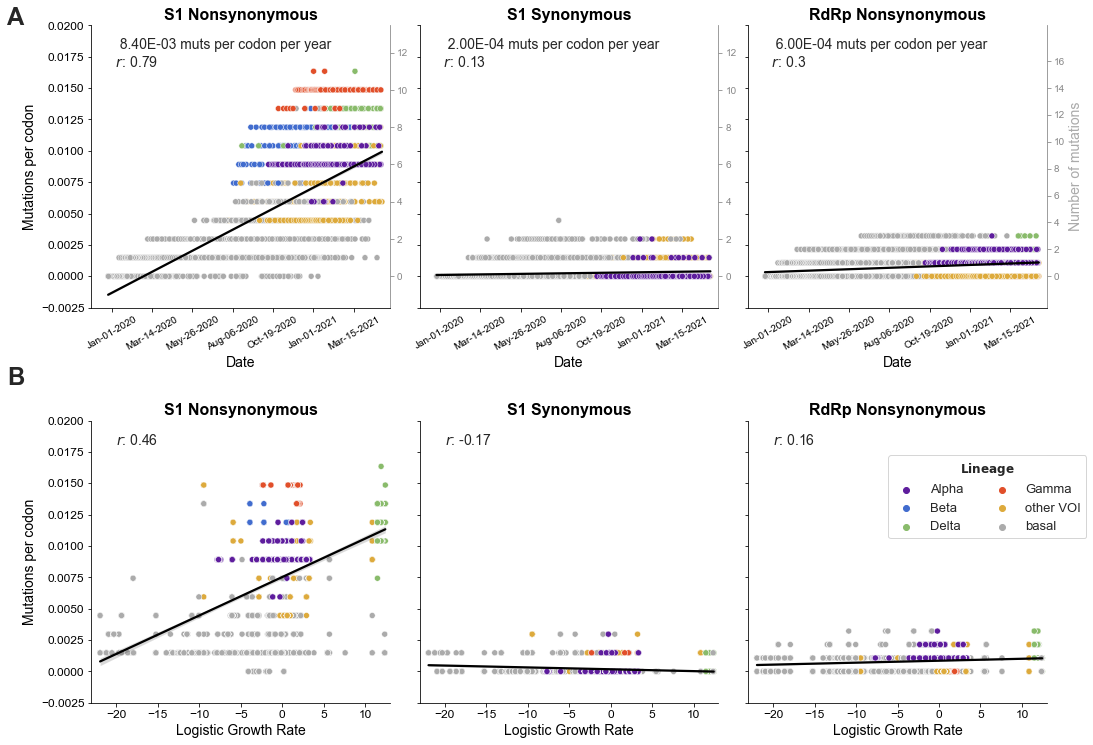

In [10]:
plot_fig1ab('plots/fig1ab_20210515.png')

Look at the relationship between mutation accumulation and logistic growth rate in other genes as well. This is Figure 1 Supplement 3

In [11]:
def plot_fig1supp_othergenes(filename=None):
    
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}

    # whether or not to plot legend, based on subplot index
    plot_legend = {**{0:False}, **{1:True}, **{x:False for x in range(2,8)}}
    
    # initialize figure format
    fig, axes = plt.subplots(4,2, figsize=(10,10), sharey=True, sharex=True)
    plt.tight_layout()
    sns.set_style('white')
    
    # plot s1, s2, rdrp, n, m, orf7a, nsp6, nsp4
    fig1supp_categories = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S2', 's2_accumulation', 'S2', 'nonsyn'),  
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('M', 'm_accumulation', 'M', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn'),
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn')]
    
    for i, ax in enumerate(axes.flat):

        ax = sns.scatterplot(x="logistic_growth", y="muts_per_codon", hue= 'manuscript_lineage',
                      hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x="logistic_growth", y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_title(f'{fig1supp_categories[i][2]}', 
                     fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, fig1supp_categories[i][0], 
                                              "logistic_growth", 'muts_per_codon')

        ax.annotate(f'$r$: {r_value}', xy=(-20,0.023), size=14, va='top', ha='left')


    # Add secondary axis showing absolute number of mutations for panel A subplots
    ax_1 = fig.axes[0].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S2'], 
                                                  lambda x: x / gene_lengths_aa['S2']))
    ax_3 = fig.axes[2].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    ax_4 = fig.axes[3].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['N'], 
                                                  lambda x: x / gene_lengths_aa['N']))
    ax_5 = fig.axes[4].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['M'], 
                                                  lambda x: x / gene_lengths_aa['M']))
    ax_6 = fig.axes[5].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['ORF7a'], 
                                                  lambda x: x / gene_lengths_aa['ORF7a']))
    ax_7 = fig.axes[6].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp6'], 
                                                  lambda x: x / gene_lengths_aa['Nsp6']))
    ax_8 = fig.axes[7].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp4'], 
                                                  lambda x: x / gene_lengths_aa['Nsp4']))
    # make secondary axis gray
    for ax in [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7, ax_8]:
        ax.spines['right'].set_color('#888888')
        ax.tick_params(colors='#888888')
    # label outer axes
    for ax in [ax_2, ax_4, ax_6, ax_8]:  
        ax.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
        
    # label x and y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [6,7]:
            ax.set_xlabel('Logistic Growth Rate', fontsize = 14)
        if i in [0, 2, 4, 6]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        # put emerging lineage legend on the bottom right plot
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.35, 1.0), 
                            fontsize=13, title_fontsize='large',
                             title = r'$\bf{Lineage}$')
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.25, wspace=0.15)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        ax.set_ylim(-0.0025,0.025)
        ax.set_xlim(-23, 13)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

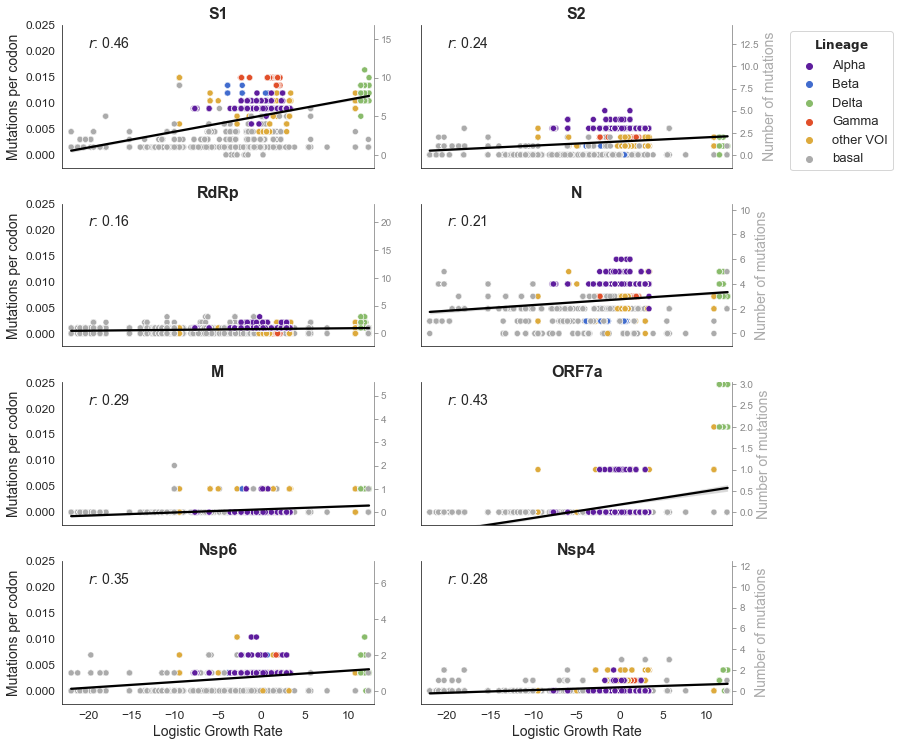

In [12]:
plot_fig1supp_othergenes(filename = 'plots/fig1_supp2_20210515.png')

The above plots show the accumulation of nonsynonymous SNPs and deletions. Now, divide mutations into SNPs and deletions and plot each versus logsitic growth. This is Figure 1 Supplement 2

In [13]:
def plot_fig1_supp_muttypessplit(filename=None):

    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}

    # plot s1, s2, rdrp, n, m, orf7a, nsp6, nsp4
    fig1supp_categories = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S2', 's2_accumulation', 'S2', 'nonsyn'),  
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('M', 'm_accumulation', 'M', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn'),
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn')]
    

    # initialize figure format
    fig = plt.figure(figsize=(10, 12))
    plt.tight_layout()
    sns.set_style('white')
    # make a subplot for each gene
    outer = gridspec.GridSpec(4, 2, wspace=0.15, hspace=0.4)


    # whether or not to plot legend, based on subplot index
    plot_legend = {**{0:{x:False for x in [0,1]}},**{1:{0:False, 1:True}}, **{y:{x:False for x in [0,1]} for y in range(2,8)}}

    # what type of mutation to plot
    type_to_plot = {0: "snps_per_codon", 1: "dels_per_codon"}

    # labels to use for mutation types:
    type_labels = {0: 'Nonsyn SNPs', 1: 'Deletions'}
    
    

    for i in range(8):
        # for each each make 2 subplots: 1 for SNPs and one for dels
        inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[i], wspace=0.1)



        for j in range(2):
            ax = plt.Subplot(fig, inner[j])
            ax = sns.scatterplot(x="logistic_growth", y= type_to_plot[j], hue= 'manuscript_lineage',
                  hue_order= list(cmap.keys()), palette=cmap,
                  data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                  ax=ax, legend=plot_legend[i][j])
            sns.regplot(x="logistic_growth", y=type_to_plot[j], scatter=False, ax=ax, 
                        data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                        line_kws={"color":'black'}, ci=95)
            # set title with gene and type of mutation
            ax.set_title(r'$\bf'+fig1supp_categories[i][0]+'$'+f'\n{type_labels[j]}', 
                         fontsize = 12)

            # run linear regression on the plot
            slope, r_value = get_linear_reg_stats(muts_information_df, fig1supp_categories[i][0], "logistic_growth", 
                                                  type_to_plot[j])
            ax.annotate(f'$r$: {r_value}', xy=(-20,0.022), size=12, va='top', ha='left')
            
            #set axis limits
            ax.set_ylim(-0.0025,0.025)
            ax.set_xlim(-23, 13)
            fig.add_subplot(ax)


            # make axes more legible
            if i in [0,2,4] and j==0:
                plt.setp(ax.get_yticklabels(), fontsize=12)
                plt.setp(ax.get_xticklabels(), visible=False)
                ax.set_xlabel('')
                ax.set_ylabel('Muts per Codon')
            elif i==6:
                plt.setp(ax.get_xticklabels(), fontsize=12)
                ax.set_xlabel('Logistic Growth Rate')
                if j==0:
                    plt.setp(ax.get_yticklabels(), fontsize=12)
                    ax.set_ylabel('Muts per Codon')
                elif j==1:
                    plt.setp(ax.get_yticklabels(), visible=False)
                    ax.set_ylabel('')
            elif i==7:
                plt.setp(ax.get_xticklabels(), fontsize=12)
                plt.setp(ax.get_yticklabels(), visible=False)
                ax.set_xlabel('Logistic Growth Rate')
                ax.set_ylabel('')
            else:
                plt.setp(ax.get_xticklabels(), visible=False)
                plt.setp(ax.get_yticklabels(), visible=False)
                ax.set_xlabel('')
                ax.set_ylabel('')
            # put emerging lineage legend on the top right plot
            if i == 1 and j==1:
                handles, labels = ax.get_legend_handles_labels()
                lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.7, 1.0), 
                                 title = r'$\bf{Lineage}$')

    # add absolute mutation count axes manually
    ax_1 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[3].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S2'], 
                                                  lambda x: x / gene_lengths_aa['S2']))
    ax_3 = fig.axes[5].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    ax_4 = fig.axes[7].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['N'], 
                                                  lambda x: x / gene_lengths_aa['N']))
    ax_5 = fig.axes[9].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['M'], 
                                                  lambda x: x / gene_lengths_aa['M']))
    ax_6 = fig.axes[11].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['ORF7a'], 
                                                  lambda x: x / gene_lengths_aa['ORF7a']))
    ax_7 = fig.axes[13].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp6'], 
                                                  lambda x: x / gene_lengths_aa['Nsp6']))
    ax_8 = fig.axes[15].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp4'], 
                                                  lambda x: x / gene_lengths_aa['Nsp4']))
    # make secondary axis gray
    for ax in [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7, ax_8]:
        ax.spines['right'].set_color('#888888')
        ax.tick_params(colors='#888888')
    # label outer axes
    for ax in [ax_2, ax_4, ax_6, ax_8]:  
        ax.set_ylabel('Number of mutations', fontsize = 12, color='#ABABAB')
        


    sns.despine(left=False, bottom=False)
    
    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

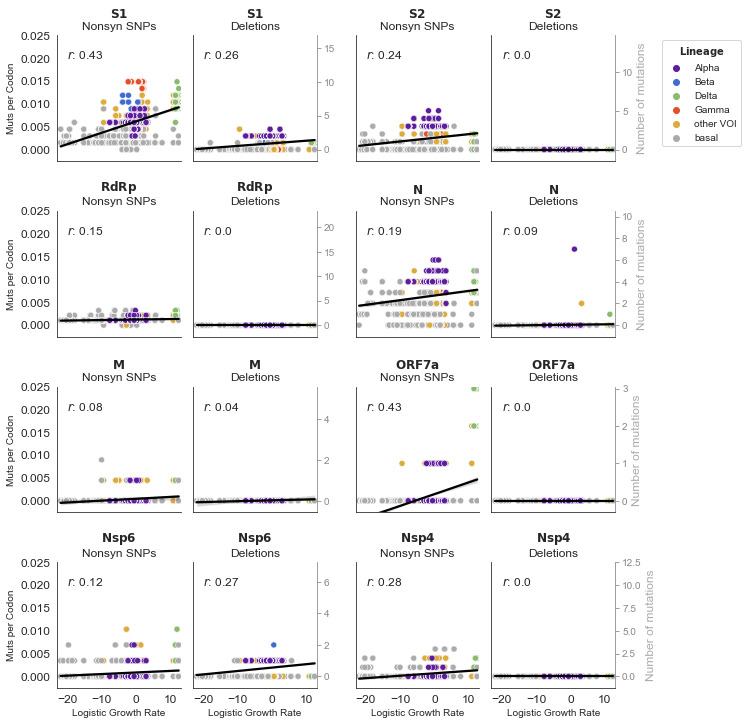

In [14]:
plot_fig1_supp_muttypessplit(filename = 'plots/fig1_supp3_20210515.png')

Plot mutation (nonsynonymous SNPs and deletions) accumulation over time for all of the same genes as above. Just for interest- This figure is not included in the paper.

In [15]:
def plot_muts_vs_time_more_genes(filename=None):
    
    # get a list of all emerging lineages
    all_emerging_lineages = sorted(list(set(muts_information_df['emerging_lineage'])))
    # take out 'basal' in order to assign colors to all other lineages
    all_emerging_lineages.remove('basal')
    colors_to_use = get_color_palette(len(all_emerging_lineages))
    cmap = dict(zip(all_emerging_lineages, colors_to_use))
    # the basal lineage will be gray
    cmap['basal'] = "#ABABAB"

    # whether or not to plot legend, based on subplot index
    plot_legend = {**{0:False}, **{1:True}, **{x:False for x in range(2,8)}}
    
    # initialize figure format
    fig, axes = plt.subplots(4,2, figsize=(10,10), sharey=True, sharex=True)
    plt.tight_layout()
    sns.set_style('white')
    
    fig1supp_categories = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S2', 's2_accumulation', 'S2', 'nonsyn'),  
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('M', 'm_accumulation', 'M', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn'),
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn')]
    
    for i, ax in enumerate(axes.flat):

        ax = sns.scatterplot(x="date", y="muts_per_codon", hue= 'emerging_lineage',
                      hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x="date", y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_title(f'{fig1supp_categories[i][2]}', fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, fig1supp_categories[i][0], 
                                              "date", 'muts_per_codon')

        ax.annotate(f'{format(slope, "10.2E")} muts per codon per year \n $r$: {r_value}', 
                    xy=(2020.0,0.022), size=12, va='top', ha='left')


    # Add secondary axis showing absolute number of mutations for panel A subplots
    ax_1 = fig.axes[0].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S2'], 
                                                  lambda x: x / gene_lengths_aa['S2']))
    ax_3 = fig.axes[2].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    ax_4 = fig.axes[3].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['N'], 
                                                  lambda x: x / gene_lengths_aa['N']))
    ax_5 = fig.axes[4].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['M'], 
                                                  lambda x: x / gene_lengths_aa['M']))
    ax_6 = fig.axes[5].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['ORF7a'], 
                                                  lambda x: x / gene_lengths_aa['ORF7a']))
    ax_7 = fig.axes[6].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp6'], 
                                                  lambda x: x / gene_lengths_aa['Nsp6']))
    ax_8 = fig.axes[7].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp4'], 
                                                  lambda x: x / gene_lengths_aa['Nsp4']))
    # make secondary axis gray
    for ax in [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7, ax_8]:
        ax.spines['right'].set_color('#888888')
        ax.tick_params(colors='#888888')
    # label outer axes
    for ax in [ax_2, ax_4, ax_6, ax_8]:  
        ax.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
        
    # label x and y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [6,7]:
            ax.set_xlabel('Date', fontsize = 14)
        if i in [0, 2, 4, 6]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        # put emerging lineage legend on the bottom right plot
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.45, 1.0), 
                             title = r'$\bf{Lineage}$')
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.25, wspace=0.15)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        ax.set_ylim(-0.0025, 0.025)
        ax.set_xlim(2019.9, 2021.38)
        plt.setp(ax.get_xticklabels(), fontsize=10)
        plt.setp(ax.get_yticklabels(), fontsize=12)

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

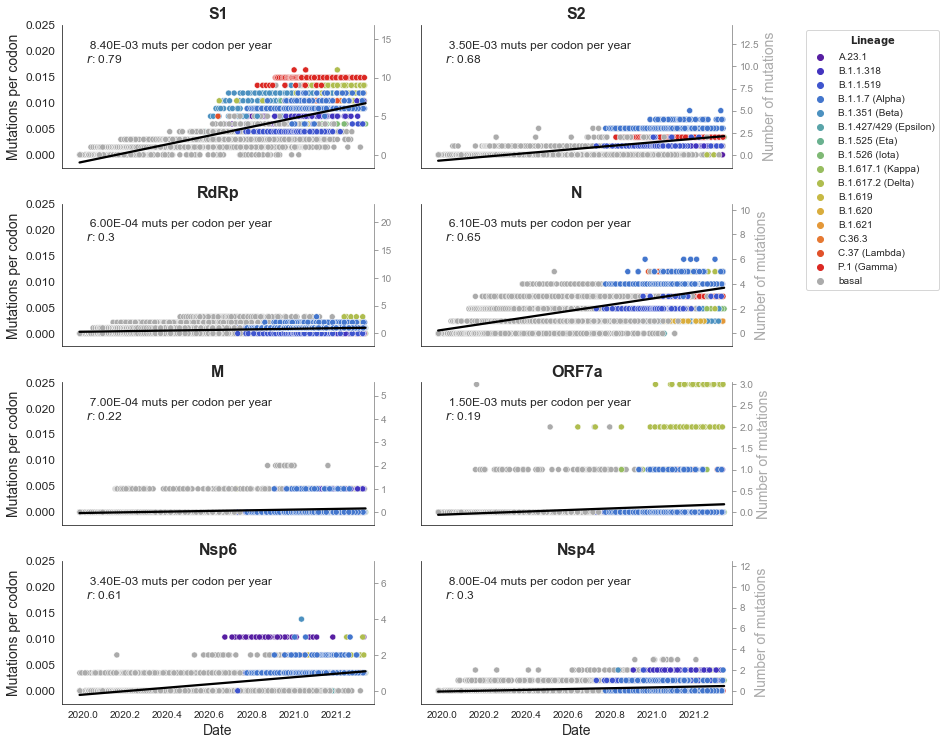

In [16]:
plot_muts_vs_time_more_genes()

The following just prints a legend for emerging lineages (which is used in Figure 1 Supplement 1 to show where each emerging lineage is on the phylogeny)

In [17]:
def print_legend(filename=None):

    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}

    fig, ax = plt.subplots(figsize=(1,1))
    plt.tight_layout()

    # plot S1 mutations versus logistic growth, color by clade membership
    ax = sns.scatterplot(x="logistic_growth", y="muts_per_codon", hue='manuscript_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                          ax=ax, legend=True, visible=False)
 
    
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(10, 10), ncol=2,
                     title = r'$\bf{Lineage}$')
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.25)
    plt.subplots_adjust(wspace=0.15)

    if filename: 
        fig.savefig(filename, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [ ]:
print_legend(filename='plots/lineages_legend.png')

The following plots RdRp syn accumulation and correlation with clade growth rate next to the panels in Figure 1. For reviewer

In [51]:
def get_randomized_rvalues(gene, nonsyn_syn):
    
    # get randomizations for rdrp_syn
    # stored in a different location because code to run randomizations was improved after the primary analysis
    if gene == 'RdRp' and nonsyn_syn=='syn':
        
        path = f'randomization_results/2021-05-15/randomizations/{gene}_{nonsyn_syn}/'
        randomization_files = [path+f for f in listdir(path) if isfile(join(path, f))]

        to_plot = pd.DataFrame(columns = ["data","iteration","gene","nonsyn_syn","r_value"])

        for data_file in randomization_files:
            with open(data_file) as json_file:
                data = json.load(json_file)
                index = int(data['iteration'])
                df = pd.DataFrame(data, index=[index])
                to_plot = pd.concat([to_plot, df])

        r_values = list(to_plot['r_value'])
        
        
        
        
    else:

        # files storing primary build randomizations
        data_files = ['randomization_results/growth_rate_stats/growth_stats_50it.json', 
            'randomization_results/growth_rate_stats/growth_stats_50itmore.json', 
            'randomization_results/growth_rate_stats/growth_stats_200its.json', 
            'randomization_results/growth_rate_stats/growth_stats_400its.json', 
            'randomization_results/growth_rate_stats/growth_stats_300its.json']
        
        # initialize dataframe to store information from all .json files where data is stored
        to_plot = pd.DataFrame(columns = ['data', 'iteration', 'gene', 'nonsyn_syn', 'r_value'])

        # read in all randomization R values
        for data_file in data_files:
            with open(data_file) as json_file:
                data = json.load(json_file)
                df = pd.DataFrame(data['growth_rate_stats'])
                to_plot = pd.concat([to_plot, df])
        
        
        
        r_values = list(to_plot[(to_plot['gene']==gene) & (to_plot['nonsyn_syn']==nonsyn_syn)]['r_value'])
            
    return r_values

In [56]:
def plot_rdrpsyn_withfig1(filename=None):
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}


    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}
    # whether or not to plot legend, based on subplot index
    plot_legend = {**{x:False for x in range(0,7)}, **{7:True}}
    
    # initialize figure format
    fig, axes= plt.subplots(2,4, figsize=(16,10), sharey=True)
    plt.tight_layout()
    sns.set_style('white')
    
    # just want to plot S1 nonsyn, S1 syn, RdRp nonsyn and RdRp syn
    categories_to_plot = regions_to_consider[:3]+regions_to_consider[-1:]
    
    for i, ax in enumerate(axes.flat):
        j = i
        x_axis_variable = "date"
        x_label = "Date"
        # j indicies 4-7 will be reset to 0-3 so that the same mutations are plotted on ax1&ax5, ax2&ax6, ax3&ax7, ax4&ax8
        # and change x-axis to logistic growth rate
        if i>=4:
            j = j-4
            x_axis_variable = "logistic_growth"
            x_label = "Logistic Growth Rate"
            
        ax = sns.scatterplot(x=x_axis_variable, y="muts_per_codon", hue= 'manuscript_lineage',
                      hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==categories_to_plot[j][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x=x_axis_variable, y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==categories_to_plot[j][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_xlabel(x_label, fontsize = 14)
        ax.set_title(f'{categories_to_plot[j][2]} {readable_labels[categories_to_plot[j][3]]}', 
                     fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, categories_to_plot[j][0], 
                                              x_axis_variable, 'muts_per_codon')
        
        # label slope and r-value. 
        if i<4:
            ax.annotate(f'{format(slope, "10.2E")} muts per codon per year \n $r$: {r_value}', 
                        xy=(2020.0,0.019), size=14, va='top', ha='left')
        # label r-value and p-value
        elif i>=4:
            
            # find p-value
            randomized_r_values = get_randomized_rvalues(categories_to_plot[j][2], categories_to_plot[j][3])
            pvalue= len([element for element in randomized_r_values if element > r_value])/len(randomized_r_values)
            
            ax.annotate(f'$r$: {r_value}\np-value: {pvalue}', xy=(-20,0.019), size=14, va='top', ha='left')
    
    # Add secondary axis showing absolute number of mutations for panel A subplots
    ax_1 = fig.axes[0].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_3 = fig.axes[2].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    ax_4 = fig.axes[3].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    # force ticks to be integers, not decimals
    ax_4.set_yticks([0,2,4,6,8,10,12,14,16])
    for ax in [ax_1, ax_2, ax_3, ax_4]:
        ax.spines['right'].set_color('#888888')
        ax.tick_params(colors='#888888')

        
    # label y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [0,4]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        if i == 3:
            ax_4.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
        # put emerging lineage legend on the bottom right plot
        if i == 7:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.7, 0.8),
                            ncol=2, fontsize=13, title_fontsize='large',
                            title = r'$\bf{Lineage}$')
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        if i<4:
            ax.set_ylim(-0.0025, 0.02)
            ax.set_xticks([p for p in ax.get_xticks()])
            ax.set_xlim(2019.9, 2021.38)
            ax.set_xticklabels([DateToStr(float(t)) for t in ax.get_xticks()], rotation=30)
            plt.setp(ax.get_xticklabels(), fontsize=10)
            plt.setp(ax.get_yticklabels(), fontsize=12)
        elif i>=4:
            ax.set_ylim(-0.0025,0.02)
            ax.set_xlim(-23, 13)
            plt.setp(ax.get_xticklabels(), fontsize=12)
            plt.setp(ax.get_yticklabels(), fontsize=12)
    
    # add figure labels
    plt.figtext(-0.05, 0.98, 'A', fontsize=24, fontweight='bold')
    plt.figtext(-0.05, 0.48, 'B', fontsize=24, fontweight='bold')
    

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

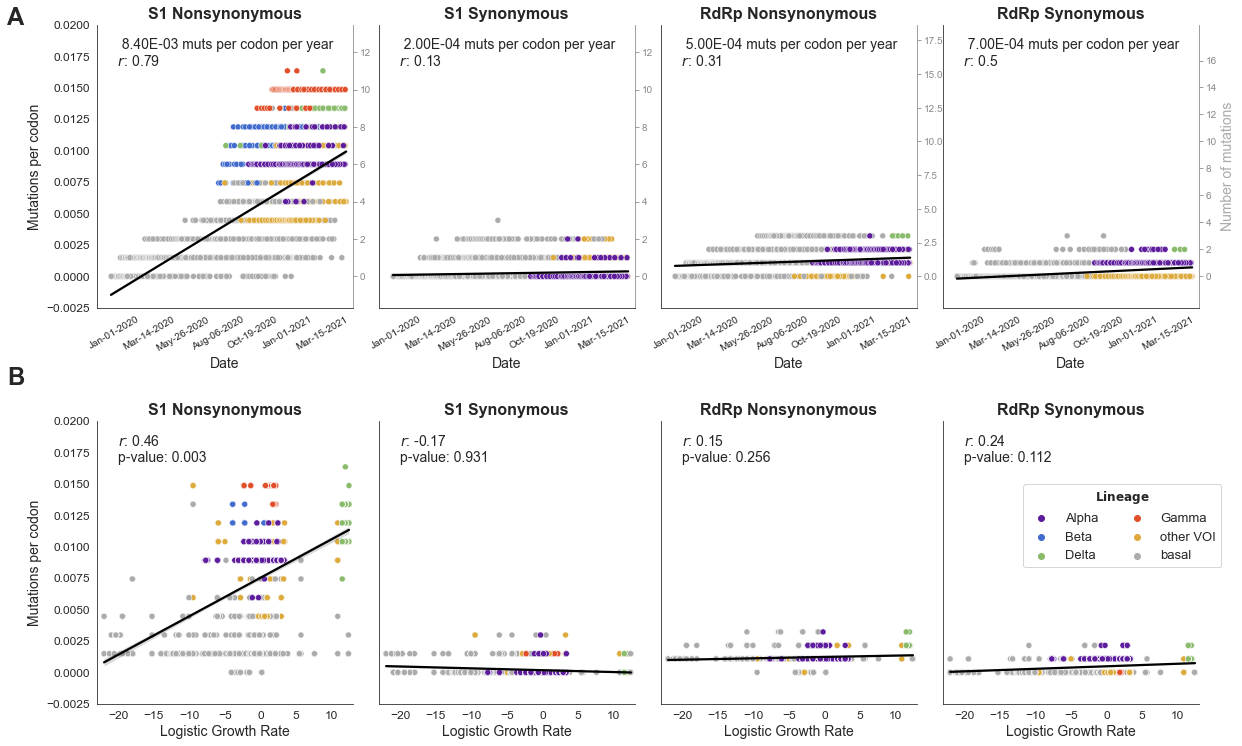

In [57]:
plot_rdrpsyn_withfig1()